In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import odeint, solve_ivp
from typing import Tuple

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print only 4 decimals
np.set_printoptions(precision=4)
torch.set_printoptions(precision=4)

PATH = "../data/"

def get_data(exp_id: str, batch: bool = True) -> pd.DataFrame:
    xls = pd.ExcelFile(PATH + f"{exp_id}_for_model.xlsx")
    df = xls.parse(0)
    df.drop(0, inplace=True)
    df['exp_id'] = exp_id
    if batch:
        df = df[df["Batch"] == 0]
    return df

def get_training_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    t_train = df['Time'].values
    u_train = df[['Biomass', 'Glucose']].values
    return np.float32(t_train), np.float32(u_train)

def ode_func(t, y, mu_max, Km, Y_XS):
    X = y[0]
    S = y[1]
    mu = mu_max * S / (Km + S)
    return [mu * X, -1 / Y_XS * mu * X]

##### Get training data

In [3]:
exp_id = 'BR01'
df = get_data(exp_id=exp_id, batch=True)
print(f'Number of training points: {len(df)}')

t_train, u_train = get_training_data(df)

# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True, device=device, dtype=torch.float32).view(-1, 1)
us_train = torch.tensor(u_train, requires_grad=True, device=device, dtype=torch.float32)

Number of training points: 8


##### Physics Informed Neural Network

In [18]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.input = nn.Linear(1, 10)
        self.hidden = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        
        self.mu_max = nn.Parameter(torch.tensor(0.5))
        self.Km = nn.Parameter(torch.tensor(0.5))
        self.Y_XS = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        x = self.input(x)
        x = self.tanh(x)
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

##### Training loop

In [19]:
model = PINN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [20]:
n_samples = 100
t_start = t_train[0]
t_end = t_train[-1]

def physics_loss(model: nn.Module, t_start, t_end):
    t = torch.linspace(t_start, t_end, n_samples, device=device, requires_grad=True).reshape(-1,1)
    u = model(t).to(device)
    u_X = u[:,0].view(-1,1)
    u_S = u[:,1].view(-1,1)
    u_t_X = torch.autograd.grad(u_X, t, grad_outputs=torch.ones_like(u_X), create_graph=True)[0]
    u_t_S = torch.autograd.grad(u_S, t, grad_outputs=torch.ones_like(u_S), create_graph=True)[0]
    error_X = u_t_X - model.mu_max * u_X * u_S / (u_S + model.Km)
    error_S = u_t_S + 1 / model.Y_XS * model.mu_max * u_X * u_S / (u_S + model.Km)
    return torch.mean(error_X**2) + torch.mean(error_S**2)

In [21]:
EPOCHS = 10000
LOSS = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    u_pred = model(ts_train)
    
    # Data Loss
    data_loss = criterion(u_pred, us_train)
    
    # Physics Loss
    ode_loss = physics_loss(model, t_start, t_end)
    
    # Initial Condition loss
    ic_loss = criterion(u_pred[0], us_train[0])
    
    # Total Loss
    loss = data_loss + ode_loss + ic_loss
    
    loss.backward()
    optimizer.step()

    LOSS.append(loss.item())
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch} || Loss: {loss.item()}')
        print(f'mu_max: {model.mu_max.item()} || Km: {model.Km.item()} || Y_XS: {model.Y_XS.item()}')

Epoch 0 || Loss: 54.19189453125
mu_max: 0.40000030398368835 || Km: 0.5999996066093445 || Y_XS: 0.5999995470046997
Epoch 500 || Loss: 0.13188903033733368
mu_max: 0.8415413498878479 || Km: 0.6438276171684265 || Y_XS: 0.44443991780281067
Epoch 1000 || Loss: 0.12037330865859985
mu_max: 0.883121907711029 || Km: 0.5253947973251343 || Y_XS: 0.47353842854499817
Epoch 1500 || Loss: 0.09537685662508011
mu_max: 0.8822687268257141 || Km: 0.4404357969760895 || Y_XS: 0.4751622676849365
Epoch 2000 || Loss: 0.09527098387479782
mu_max: 0.8735899329185486 || Km: 0.39048629999160767 || Y_XS: 0.4761100113391876
Epoch 2500 || Loss: 0.06702161580324173
mu_max: 0.8835763931274414 || Km: 0.3539183437824249 || Y_XS: 0.4612472951412201
Epoch 3000 || Loss: 0.07630522549152374
mu_max: 0.8654714226722717 || Km: 0.33385515213012695 || Y_XS: 0.47076940536499023
Epoch 3500 || Loss: 0.05401773750782013
mu_max: 0.8649693131446838 || Km: 0.2980535328388214 || Y_XS: 0.456676721572876
Epoch 4000 || Loss: 0.240651264786720

KeyboardInterrupt: 

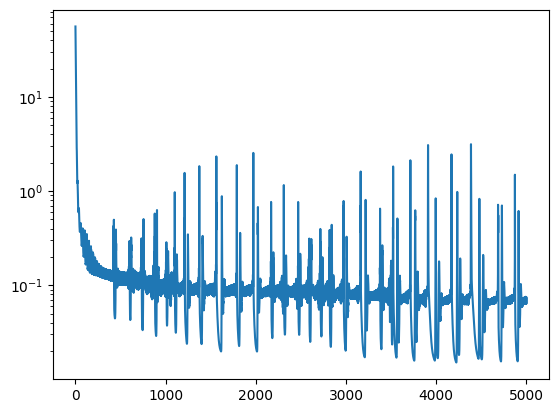

In [7]:
# Plot LOSS 
import matplotlib.pyplot as plt

plt.plot(LOSS)
plt.yscale('log')
plt.show()